<a href="https://colab.research.google.com/github/nicolasrondan/cv-um-2023/blob/main/practico-5/Practico_5_Detecci%C3%B3n_de_objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALACION (SOLO EJECUTAR EN GOOGLE COLAB) 
***Importante*** *: El codigo de instalción hace que el entorno se reinicie, luego de reiniciar volver a correr todas las celdas (Incluso montar Google drive) para que los paquetes necesarios queden instalado correctamente.*

In [ ]:
#@title Installing condacolab (ONLY GOOGLE COLAB)
!pip install -q condacolab

In [ ]:
#@title install conda
import condacolab
condacolab.install()

In [ ]:
#@title check conda
import condacolab
condacolab.check()

In [ ]:
#@title install cyvlfeat
!conda install -c conda-forge cyvlfeat -y

In [ ]:
!pip install imutils

# Introducción

En este práctico vamos a explorar la detección de objetos basada en sliding window. Para ello vamos a implementar una versión simplificada del detector propuesto en el articulo ’[Histograms of oriented gradients for human detection](https://hal.inria.fr/inria-00548512/document)’ de Dalal & Triggs. Este uno de los articulos más citados en el campo de computer vision. El articulo describe un algoritmo para poder detectar personas caminando ("*pedestrians*") utilizando una estrategia de sliding window y features basados en histogramas de gradientes.


En este práctico vamos a implementar la función `sliding_window` que nos permite aplicar el algoritmo "*sliding window*" y detectar objetos en la misma.

## Datos de Entrenamiento
Para poder realizar el práctico es necesario descargar los archivos de entrenamiento para ello vamos a ejecutar el siguiente código:

In [ ]:
import gdown

In [ ]:
# Downoald data file to '/content/sample_data/data.zip' change this if not running in colab
file_id = '1ZifijFe_kWdYfI0d5kn9iHiJI97Enfth'
src_url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
output_file = '/content/sample_data/data.zip'
gdown.download(src_url, output_file, quiet=False,use_cookies=False)

In [ ]:
# uncompressing data file to '/content/sample_data/data' change this if not running in colab
import shutil
output_folder = '/content/sample_data/'
shutil.unpack_archive(output_file, output_folder)

### Set working folder

In [ ]:
%cd /content/sample_data/

# Sliding Window 

Como vimos en el teórico el algoritmo *sliding window* para detección de objetos consiste de 4 partes:

1. Extraer todas las posiciones donde puede haber un objeto a detectar.  (Sliding Window)
2. Representar los parches de la imagen para poder clasificarlos. (HoG Features)
3. Clasificar cada uno de los parches. (SVM)
4. Resolver la ubicación exacta de una detección. (Non Max Suppresion)

En este práctico vamos a utilizar este flujo para hacer detección de objetos.

\**Durante todo el práctico vamos a trabajar con un tamaño de ventana de 300x100 pixeles*

# Parte 1: Entrenar un SVM

La primera parte de este ejercicio consiste en entrenar un SVM para poder clasificar si una imagen corresponde a una persona caminando o no. Para entrenar el clasificador se provee la carpeta `./trainSVM`. Esta carpeta contiene ejemplos positivos y negativos de imágenes de personas Los archivos `matfile/pos_train_names.mat` y `matfile/neg_train_mat.mat` proveen los nombres de archivo para cargar las imágenes de entrenamiento. Las funciones `negative_data` y `positive_data` que están incluidas en este práctico nos permiten cargar los datos de entrenamiento extrayendo features HoG y generando las etiquetas correspondientes.

Para entrenar un SVM en esta sección vamos utilizar el clasificador [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) de sklearn que esta basado en [libSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/)

Para extraer los features hog vamos a utilizar la función `hog` de vlfeat pueden consultar la documentación de la función ejecutando el siguiente código luego de importar la misma.



```
help(hog)
```



## SVM Lineal
Para poder entrenar un SVM lineal con SVC podemos utilizar el siguiente código:



```
classifier = SVC(kernel='linear', C=0.05 , random_state=0)
classifier.fit(X, y)
classifier.predict(X_test)
classifier.decision_function(X_test)

```

El cual entrena un clasificador svm linela con un parámetro de regularización C=0.05. Las funciones ´predict´ y ´decision_function´ nos permiten hacer una predicción y saber el score del SVM en cada dato de entranda.


## Kernel SVM

Para entrenar un SVM con kernel RBF tal como vimos en el teórico del curso se puede utilizar el siguiente código:

```
classifier = SVC(kernel='rbf', C=0.05 , random_state=0)
classifier.fit(X, y)
classifier.predict(X_test)
classifier.decision_function(X_test)

```

Para entrenar un SVM con kernel va a ser necesario utilizar un parametro de regularización distinto al SVM lineal



## Parte 1: Código

### Imports 

In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from scipy.io import loadmat
from cyvlfeat.hog import hog
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from imutils.object_detection import non_max_suppression
from typing import Tuple, List, Optional

In [ ]:
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
#mpl.rc('figure', figsize=(20,10))

### Funciones Auxiliares 

In [ ]:
def load_images(images_dir:str,image_names:List[str],image_size=(100,300))-> List[np.ndarray]:
    """ Given a data folder and a list of images loads images and hog representation with the selected
    categories. Images should be oganized under folders with the category name

    Args:
        images_dir: Path of folder containing images to load
        image_names: List containing image names of images to load
        image_size: Desired image size in which to resize selected images
    Returns:
        images: List containing the loaded images
    """
    number_of_samples = len(image_names)
    images = []

    for idx, image_name in tqdm(enumerate(image_names), total=number_of_samples):

      image_path = os.path.join(images_dir,image_name)
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image_resized = cv2.resize(image_rgb,image_size)
      images.append(image_resized)
    
    return images

In [ ]:
def extract_hog_features(image:np.ndarray,cell_size=32) -> np.ndarray:
    """ Given an image extracts the hog representation for the selected cell
    size and returns a 1D vector with the representation

    Args:
        image: image to extract features from
        cell_size: cell size of the HoG representation

    Returns:
        Returns 1D vector with image HoG representation
    """
    image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    hog_representation = hog(image_gray, cell_size)
    feature_vector = hog_representation.flatten()
    return feature_vector

In [ ]:
def generate_hog_visualization(image:np.ndarray, cell_size=32):
    """ Given an image generate the hog visualization for the 
    selected cell size

    Args:
        image: image to extract features from
        cell_size: cell size of the HoG representation
    Returns:
        Returns image with HoG visualization
    """
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    _,hog_vis = hog(gray_image, cell_size, visualize=True)
    return hog_vis    

### Cargar Datos de Entrenamiento

In [ ]:
pos_train_names = loadmat('matfile/pos_train_names.mat')
neg_train_names = loadmat('matfile/neg_train_names.mat')
pos_train_names = pos_train_names['pos_train_names']
neg_train_names = neg_train_names['neg_train_names']

In [ ]:
neg_train_names = [name.strip() for name in neg_train_names]
pos_train_names = [name.strip() for name in pos_train_names]

In [ ]:
data_folder = './train_data'

In [ ]:
positive_images_dir = os.path.join(data_folder,'pedestrian')
negative_images_dir = os.path.join(data_folder,'no_pedestrians')

##### Cargar Imagenes Positivas

In [ ]:
positive_images = load_images(positive_images_dir,pos_train_names)
positive_labels = np.ones([len(positive_images),1])

##### Cargar Imagenes Negativas

In [ ]:
negative_images = load_images(negative_images_dir,neg_train_names)
negative_labels = np.zeros([len(negative_images),1])

##### Crear Matrices de Features HoG

In [ ]:
positive_feature_list = [extract_hog_features(image) for image in tqdm(positive_images)]

In [ ]:
positive_feature_matrix = np.array(positive_feature_list)
print(positive_feature_matrix.shape)

In [ ]:
negative_feature_list = [extract_hog_features(image) for image in tqdm(negative_images)]

In [ ]:
negative_feature_matrix = np.array(negative_feature_list)
print(negative_feature_matrix.shape)

### Visualización de ejemplos
Vamos a visualizar algunos ejemplos de features HoG para imagenes de personas (*ejemplos positivos*) y para imagens de no personas (*ejemplos negativos*)

In [ ]:
from random import sample

#### Visualización de ejemplos positivos

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(12,12))
positive_sample = sample(positive_images,3)

for idx, image in enumerate(positive_sample):
  hog_visulization = generate_hog_visualization(image)
  axes[0,idx].imshow(image)
  axes[1,idx].imshow(hog_visulization)

#### Visualización de ejemplos negativos

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(12,12))
negative_sample = sample(negative_images,3)

for idx, image in enumerate(negative_sample):
  hog_visulization = generate_hog_visualization(image)
  axes[0,idx].imshow(image)
  axes[1,idx].imshow(hog_visulization)

### Entrenamiento del SVM

#### Split de Datos
Antes de entrenar nuestro clasificador SVM vamos a separar nuestros datos en dos sub-sets uno para **entrenamiento** y otro para **evaluación** de los resultados de nuestro clasificador. Es importante utilizar este tipo de estrategia para poder validar que nuestro algoritmo esté generalizando correctamente y no solo funcione correctamente con los datos de entrenamiento.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
total_data = np.vstack([positive_feature_matrix, negative_feature_matrix])
total_labels = np.vstack([positive_labels, negative_labels])

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(total_data, total_labels, test_size=0.1, random_state=50)

#### Entrenar clasificador
Vamos a utilizar nuestros datos de entrenamiento para entrenar nuestro clasificador. Este clasificador debería poder clasificar los distintos parches (ventanas) en una imagen para decidir si contienen una persona o no.

In [ ]:
classifier = SVC(kernel='linear', C=0.05, random_state=0)
classifier.fit(train_data, train_labels)

#### Evaluar Clasificador
En esta sección vamos a Evaluar el clasificador utilizando dos metricas el accuracy y la matriz de confusion para verificar el precision y recall. Vamos a visualizar la matriz de confusion en el siguente formato:

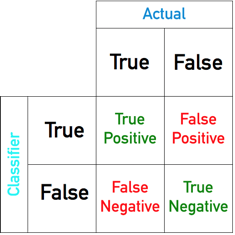

In [ ]:
test_predictions = classifier.predict(test_data)

In [ ]:
model_accuracy = np.mean(test_predictions == np.squeeze(test_labels))*100
print('model accuracy on test data is {:.2f}%'.format(model_accuracy))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions, labels=[1,0])
sns.heatmap(cf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues',xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])
plt.show()

# Parte 2: Sliding Window

Hasta el momento hemos ejecutado código que nos permite cargar los datos de entrenamiento y entrenar un SVM. En esta sección es necesario implentar la función `sliding_window` que es la que va a aplicar el algoritmo sliding window. Esta función toma la imagen y aplica el clasificador entrenado en cada region para obtener el score asociado a cada parche de la imagen. 

Para obtener el score de cada parche o ventana de la imagen de puede utilzar el siguiente código:


```
scores = clf.decision_function(patch)
```

La función `decision_function` devuelve los scores de cada punto utilizando función de clasificación:

$f(x)= w.x + b$


In [ ]:
def sliding_window(image:np.ndarray, window_size:Tuple[int], classifier:SVC, stride:int=1)->Tuple[np.ndarray,np.ndarray]:
    """ Function to extract windows positions and calculate and detection score per 
    position.

    Args:
    image : Input image as loaded with openCV in grayscale .
    window_size : Window size in format W x H used to extract windows from the 
      original image.
    classifier : SVC classifier used to evaluate each window position on the 
      image. Must implement the method predict_proba
    stride: stride for the sliding window.

    Returns:
    positions: All extracted boundig boxes positions
    scores: Scores corresponding to each bounding box position
   
    """

    positions=[]
    scores=[]
    # Your code
    return positions, scores

### Visualizar ejemplos del set de testing
Vamos a visualizar los resultados en una de las imagenes del set de testing para detección (carpeta en la ruta `./test/`). Luego de ejecutar el siguiente código para una imagen ejecutarlo para el resto de las imágenes en la carpeta y visualizar los resultados.

**La función `sliding_window` si se ejecuta con el parametro `stride=1` puede demorar algunos minutos*


In [ ]:
test_image = cv2.imread('./test/example2.png')
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [ ]:
locations, scores = sliding_window(test_image_gray, [100,300], clf, stride=10)

#### Visualizar el histograma de scores en una imagen
Podemos visualizar el histograma de valores de los parches para poder filtrar aquellos parches que consideramos tienen valores muy positivos (ej. mayores a 1) y así seleccionar aquellos candidatos que sea más probable que contengan una persona.

In [ ]:
hist = np.histogram(scores,bins=20)

In [ ]:
mpl.rc('axes.spines',top=True,bottom=True,left=True,right=True);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(0,0,0,1));
mpl.rc(('xtick','ytick'),color=(0,0,0,1));

In [ ]:
plt.hist(scores, bins=20)
plt.axis('on')
plt.show()

Para esta sección vamos a seleccionar el umbral de clasificación en 0.5

In [ ]:
positive_boxes = locations[scores > 0.5]
print(f'Number of positive boxes: {positive_boxes.shape[0]}')

### Visualización de resultados finales


In [ ]:
## Hacemos el merge de las regiones ##
boxes = non_max_suppression(positive_boxes,probs=None, overlapThresh=0.4)
print(f'Number of positive boxes after NMS: {boxes.shape[0]}')

In [ ]:
def draw_boxes(image, boxes):
    out_image = image.copy()
    plt.figure(figsize=(10,20))
    for box in boxes:
      out_image = cv2.rectangle(out_image,(box[1],box[0]),(box[3],box[2]),color=(255,0,0))
    
    plt.imshow(out_image)
    plt.show()


In [ ]:
draw_boxes(test_image,boxes)

# Mejoras
Hastas el momento implementamos un detector de objetos (personas) que es lento y comete varios errores. Vamos a intentar implementar las siguientes mejoras:


1. Modificar los parametros del extractor de features hog y el clasificador SVM para obtener mejores resultados finales en la detección. También se pueden descargar más imagenes.

2. Hasta ahora estamos seleccionando un umbral fijo para decidir cuales son detecciones positivas y negativas. Podemos construir la curva de precision y recall variando nuestro umbral desde [-1,1]. Construir esta curva y graficarla y compararla con la curva del reesultado anterior.


In [ ]:
def plot_precision_recall(test_scores:np.ndarray, test_labels:np.ndarray):
    """ Function to plot precision vs recall curve

    Args:
    test_scores : predicted scores for the selected data .
    test_labels : ground truth scores of the selected data

    Returns:
    No return values, plots precision and recall for the selected predicted and
    ground thruth data.
    """
    
    test_labels = np.squeeze(test_labels)
    total_positives = np.sum(test_labels == 1)
    total_negatives = np.sum(test_labels == 0)
    precisions = []
    recalls = []

    for threshold in np.arange(-1,1,0.01):
      #predictions = np.zeros(test_scores.shape)
      predictions = test_scores > threshold
      predicted_positives = np.sum(predictions)
      true_positives = np.sum(np.bitwise_and((predictions == 1), (test_labels==1)))
      true_negatives = np.sum(np.bitwise_and((predictions == 0), (test_labels==0)))

      precision = true_positives / predicted_positives
      recall = true_positives/ total_positives
      precisions.append(precision)
      recalls.append(recall)
    
  
    plt.plot(recalls,precisions,'b-')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()